# **Chap 6：计算机视觉**

In [1]:
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import time
from source.code import ch6
from source.code import utils

2023-05-21 00:38:08.123413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 00:38:08.266296: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 00:38:08.296833: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-21 00:38:09.069831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **6.4 语义分割**

在计算机视觉领域另一个重要的任务是**语义分割**（**Semantic Segementation**），与目标检测不同，语义分割除了在图像中检索出目标所在的未知，还**需要标识出目标的像素级区域**，即**语义分割模型需要判断一张图像上的每一个像素的真实含义**
* 与目标检测相比，语义分割对目标边框的标注更加精细

CV 中与语义分割相似的两个重要问题还有**图像分割**（**Image Segmentation**）和**实例分割**（**Instance Segmentation**）
* **图像分割**需要将图像划分为若干组成区域，通常利用图像中像素之间的相关性来解决
    * 它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义
* **实例分割**也叫同时检测并分割（**Simultaneous Detection and Segmentation**），它研究如何识别图像中**各个目标实例**的像素级区域
    * 与语义分割不同，实例分割不仅需要区分语义（目标类别），**还要区分不同的目标实例**
    * 例如，如果图像中有两条狗，语义分割只需要判断他们所在的像素区域代表狗，实例分割需要区分像素属于的两条狗中的哪一条

### **6.4.1 语义分割数据集**

语义分割数据集其**语义区域的标注和预测是像素级的**，我们使用 `Pascal VOC2012` 语义分割数据集，它是最重要的语义分割数据集之一，难度也非常适合入门语义分割

`Pascal VOC2012` 数据集存放在路径 `../source/data/cv/pascal_VOC2012/` 中，我们之后任务需要使用到的目录包括：
* `pascal_VOC2012`
    * `ImageSets`
        * `Segmentation`
            * `train.txt`
            * `val.txt`
    * `JPEGImages`
    * `SegmentationClass`

其中
* `train.txt` 和 `val.txt` **保存了训练集和测试集的文件名称**
* `JPEGImages` 文件夹包含了**所有的输入图像**，格式为 `JPEG`，是 RGB 三通道彩色图像
* `SegmentationClass` 文件夹包含了所有图像**对应的语义分割标注结果**（即**标签**），用 `PNG` 格式保存

函数 `read_pascalVOC2012_images()` 负责从文件路径加载 `JPEG` 图像及对应的像素级标注标签，并转换为张量，

In [3]:
def load_pascalVOC2012_images(path : str, dataset : str="train"):
    # 读取 Pascal VOC2012 数据
    import os
    dataset = "train.txt" if dataset == "train" else "val.txt" # 确认文件路径
    files = os.path.join(path, "ImageSets", "Segmentation", dataset)

    # 读取数据集对应的图像文件名
    with open(files,"r") as f:
        images_names = f.read().split()
    
    features, labels = [], [] # 初始化特征和标签
    for i, file in enumerate(images_names):
        feature_path = os.path.join(path, "JPEGImages", f'{file}.jpg')
        features.append(tf.image.decode_jpeg(tf.io.read_file(feature_path),channels=3))

        label_path = os.path.join(path, "SegmentationClass", f'{file}.png')
        labels.append(tf.image.decode_png(tf.io.read_file(label_path),channels=3))
    
    return features, labels

In [4]:
path = "../source/data/cv/pascal_VOC2012/"
X_train, y_train = ch6.load_pascalVOC2012_images(path,dataset="train")

2023-05-20 09:54:49.436127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 09:54:50.128624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


我们简单定义一个函数 `show_segmentation_labels` 来绘制语义分割的标注结果

In [5]:
def show_segmentation_labels(images, labels, figsize=(12,4), ncol=4,dpi=50):
    fig, ax = plt.subplots(2,ncol,figsize=figsize,dpi=dpi)
    ax = ax.flatten()
    for i, (img,label) in enumerate(zip(images,labels)):
        ax[i].imshow(img)
        ax[i+ncol].imshow(label)
    plt.tight_layout()
    return

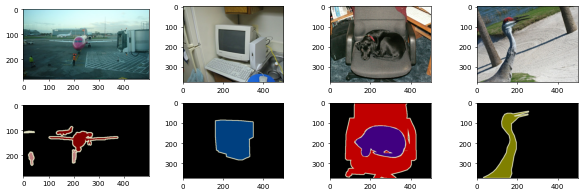

In [6]:
fig = ch6.show_segmentation_labels(images=X_train[0:4],labels=y_train[0:4])

在标签图像中，**白色和黑色分别表示边框和背景**，而**其他颜色则对应不同的目标类别**，每种颜色对应的 **RGB 颜色值有其对应的类别标签**

In [7]:
VOC_CLASSES = {
    "background": [0, 0, 0],   "aeroplane": [128, 0, 0],    "bicycle": [0, 128, 0],
    "bird": [128, 128, 0],     "boat": [0, 0, 128],         "bottle": [128, 0, 128],
    "bus": [0, 128, 128],      "car": [128, 128, 128],      "cat": [64, 0, 0],
    "chair": [192, 0, 0],      "cow": [64, 128, 0],         "diningtable": [192, 128, 0],
    "dog": [64, 0, 128],       "horse": [192, 0, 128],      "motorbike": [64, 128, 128],
    "person": [192, 128, 128], "potted piant": [0, 64, 0],  "sheep": [128, 64, 0],
    "sofa": [0, 192, 0],       "train": [128, 192, 0],      "tv/monitor": [0, 64, 128]
}

在执行语义分割任务时，我们**只需要预测目标类别的索引**，而没有必要预测类别的 RGB 值
* 我们可以借助上面的字典，实现**类别 RGB 值到类别索引的映射**

In [8]:
def create_RGBcolormap_labels(VOC_CLASSES : dict):
    # 构造从 RGB 值到类别索引的映射
    # 三通道数据，每个通道有 0~255 共 256 个取值，所有像素组合数为 256^3
    rgb_to_label = np.zeros((256**3,), dtype=np.int32) 
    for i, (key,value) in enumerate(VOC_CLASSES.items()):
        rgb_to_label[(value[0] * 256 + value[1]) * 256 + value[2]] = i
    return tf.constant(rgb_to_label,dtype=tf.int32)

* 接下来，给定每个 RGB 像素，我们可以使用映射 `rgb_to_label` 将其转换到类别索引

In [9]:
def get_RGBlabel_index(RGB : tf.Tensor, rgb_to_label : tf.Tensor):
    # 将 RGB 像素信息映射到类别索引
    # RGB 形状：(height, width, channels)
    RGB = tf.cast(RGB,dtype=tf.int32)
    index = (RGB[:,:,0] * 256 + RGB[:,:,1]) * 256 + RGB[:,:,2] # 形状：(height, width)

    # 输出形状：(height, width)
    return tf.gather(rgb_to_label,index)

我们可以截取第一张样本图像中，**飞机头部附近区域**的类别索引，可以看到飞机**机身的索引为 1， 背景的索引为 0**

In [10]:
rgb_to_label = ch6.create_RGBcolormap_labels(ch6.VOC_CLASSES) # 创建映射
sample_label = ch6.get_RGBlabel_index(y_train[0], rgb_to_label) # 对 RGB 标签进行映射
sample_label[105:115, 130:140] 

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=int32)>

在构造模型训练所需要使用的**批量数据**时，我们还需要**保证每张图像具有相同的尺寸**
* 在之前的实验中，我们使用过 `Resize` 操作来实现的，但在语义分割任务中，`Resize` 不但需要对输入图像进行，还需要同时对标签进行，**对标签的** `Resize` **可能不够精确，尤其在不同语义边缘区域**，导致人为加入了噪声
* 为了避免该问题，在语义分割任务中，人们常用**裁剪** `Crop` 将图像修改为固定形状，我们可以使用**图像增广中的随机裁剪**来实现，确保**裁剪输入图像和对应的标签产生相同的区域**

In [11]:
def random_crop(feature, label, height : int, width : int):
    # feature 和 label 形状：(h, w, 3)
    # 随机裁剪输入特征和标签图像
    concat = tf.concat([feature, label],axis=2) # 先进行拼接，统一裁剪，维度 (h, w, 6)
    concat = tf.image.random_crop(concat, size=(height, width, 6))
    # 重新拆分为特征和标签
    feature, label = concat[:,:,0:3], concat[:,:,3:]
    return feature, label

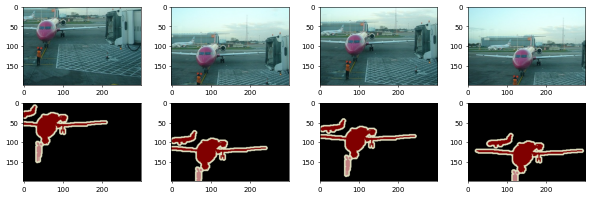

In [12]:
images_crop, labels_crop = [], []
for _ in range(4):
    output = random_crop(X_train[0], y_train[0], height=200, width=300)
    images_crop.append(output[0]); labels_crop.append(output[1])
ch6.show_segmentation_labels(images_crop, labels_crop, figsize=(12,4), ncol=4)

最后，我们将所有的功能打包封装，创建 `SegmentationDataLoader` 类，用于**产生批量数据**
* 由于我们要进行**随机裁剪**，而数据集中**有些图像的尺寸可能小于随机裁剪所指定的输出尺寸**，这些样本可以通过 `filter` 函数**移除掉**
* 在数据集加载时，可以**对输入特征进行归一化操作**，例如将像素值调整到 `[0,1]` 区间
* 我们使用了图像增广部分介绍的 `num_parallel_calss` 和 `prefetch` 技巧，加速图像的预处理

`SegmentationDataLoader` 已经写入 `../source/code/ch6.py`

In [48]:
class SegmentationDataLoader:
    def __init__(self, path : str, dataset : str, crop_size : list=[200, 300], batch_size : int=32) -> None:
        # 读取数据集
        self.X, self.Y = load_pascalVOC2012_images(path, dataset)
        self.crop_size = crop_size # 裁剪大小
        self.batch_size = batch_size
        
        # 过滤数据集
        self.X = self.filter(self.X)
        self.Y = self.filter(self.Y)

        # 对特征进行规范化
        self.mean = tf.constant([0.485, 0.456, 0.406]) # 数据集 RGB 通道均值
        self.std = tf.constant([0.229, 0.224, 0.225]) # 数据集 RGB 通道标准差

        # 创建 RGB 到类别索引的映射
        self.rgb_to_label = create_RGBcolormap_labels(VOC_CLASSES)

        print("read %s dataset with %d images"%(dataset, len(self)))

    # 过滤数据集
    def filter(self, images):
        images = [img for img in images if img.shape[0] >= self.crop_size[0] 
                                       and img.shape[1] >= self.crop_size[1]]
        return images

    # 标准化数据集
    def make_sample(self, img, label):
        feature, label = random_crop(img, label, self.crop_size[0], self.crop_size[1])
        # 做归一化
        feature = self.normalize(feature)
        # 从 RGB 转换到类别索引
        label = get_RGBlabel_index(label, self.rgb_to_label)
        return feature, label
    
    def normalize(self, img):
        return (tf.cast(img, dtype=tf.float32) / 255.0 - self.mean) / self.std
    
    # 给定索引 idx，访问数据
    def __getitem__(self, idx):
        return self.make_sample(self.X[idx], self.Y[idx])
    
    # 创建数据集
    def create_dataset(self):
        # 定义一个迭代器，从 self.X, self.Y 中读取图片
        # 因为 self.X 中每个元素的大小不同，我们没办法使用 tf.data.Dataset.from_tensor_slices
        def help_generator():
            for img, label in zip(self.X,self.Y):
                yield img, label
        
        # 创建 DataLoader
        dataset = tf.data.Dataset.from_generator(help_generator,
            output_signature=(tf.TensorSpec(shape=(None,None,3),dtype=tf.uint8),
                              tf.TensorSpec(shape=(None,None,3),dtype=tf.uint8)))
        # 加工样本，并通过 num_parallel_calls 和 prefetch 加速
        dataset = dataset.map(lambda x,y : self.make_sample(x,y),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(self.batch_size).shuffle(self.batch_size)
        return dataset
    
    # 数据集大小
    def __len__(self):
        return len(self.X)

设批量大小为 32，我们定义数据迭代器，打印第一个小批量的形状，**测试功能是否正常**

In [15]:
path = "../source/data/cv/pascal_VOC2012/"
crop_size = (320, 480)
train_ds = ch6.SegmentationDataLoader(path,"train",crop_size)
valid_ds = ch6.SegmentationDataLoader(path,"valid",crop_size)

read train dataset with 1114 images
read valid dataset with 1078 images


In [16]:
for x_batch, y_batch in train_ds.create_dataset():
    break
print("特征形状：",x_batch.shape) # 形状：(batch_size, crop_size, 3)
print("标签形状：",y_batch.shape) # 形状：(batch_size, crop_size)

特征形状： (32, 320, 480, 3)
标签形状： (32, 320, 480)


### **6.4.2 转置卷积**

之前我们所接触的卷积神经网络算子，包括**卷积层**，**汇聚层**，由它们构成的卷积块堆叠能够实现图片的**下采样**，不断减小图片的高宽，得到**感受野越大，囊括全图信息的特征图**

但在语义分割任务中，我们需要**做出像素级的预测**，即**最后特征图抽取的信息应该是局部的像素级信息**，显然此时之前的卷积算子不能满足我们的需求，人们提出一种新的卷积运算**转置卷积**来将一个尺寸较小的**特征图上采样到尺寸较大的特征图**
* 如果**上采样后能使得模型输入和输出的空间维度相同**，则这种模型在语义分割这种像素级预测问题中将十分方便

**(1) 转置卷积**

我们先从最简单的情况说明转置卷积，假设：
* **输入输出通道数只有一个**，设步幅为 1 且没有填充
* 假设我们有一个 $n_h\times n_w$ 的输入图像，一个 $k_h\times k_w$ 的转置卷积核

以步幅 1，卷积核会在输入图像上向右向下滑动 $n_hn_w$ 次，每次滑动计算得到一个中间结果，共有 $n_hn_w$ 个中间结果，每个中间结果的**形状都是** $(n_h + k_h-1)\times (n_w + k_w - 1)$，这些**中间结果被初始化为零**
* 输入张量中的每个元素都乘以卷积核，然后放置在其中间结果的**对应位置**（该位置与输入张量中元素的位置一一对应）
* 最后的输出结果，**将得到的** $n_hn_w$ **个中间结果相加**

下面展示了一个输入大小为 $2\times 2$，卷积核大小也为 $2\times 2$ 的转置卷积计算过程，输出大小为 $3\times 3$，**转置卷积通过卷积核“广播”输入元素，从而产生大于输入的输出**

<img src="../source/Chap6/转置卷积.png" width=1000>

我们可以像在卷积神经网络中介绍的一样，实现一个 `trans_corr2d()`，以展示转置卷积的计算过程

In [122]:
def trans_corr2d(X : tf.Tensor, kernel : tf.Tensor):
    # 获取维度
    n_h, n_w = X.shape
    k_h, k_w = kernel.shape
    o_h, o_w = n_h + k_h - 1, n_w + k_w - 1
    # 初始化输出
    H = np.zeros((o_h,o_w),dtype=np.float32)
    for i in range(n_h):
        for j in range(n_w):
            H[i:(i + k_h), j:(j + k_w)] += X[i,j] * kernel
    return tf.constant(H)

下面，按照上图中的数据，测试函数功能

In [123]:
X = tf.constant([[0.0, 1.0], 
                 [2.0, 3.0]])
kernel = tf.constant([[0.0, 1.0], 
                      [2.0, 3.0]])
ch6.trans_corr2d(X,kernel)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.,  0.,  1.],
       [ 0.,  4.,  6.],
       [ 4., 12.,  9.]], dtype=float32)>

`Tensorflow` 中提供了转置卷积的 API，`tf.keras.layers.Conv2DTranspose`
* 将卷积核参数设置为前面所使用的，可以验证计算结果相同

In [124]:
# 实例化转置卷积层
layer = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=2,strides=1,use_bias=False)
# 设置卷积核参数
_ = layer(X[None,:,:,None]) # 添加两个额外维度，先调用一次初始化参数
layer.weights[0].assign(tf.reshape(kernel,(2,2,1,1))) # 修改参数

# 推理结果
layer(X[None,:,:,None])[0,:,:,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.,  0.,  1.],
       [ 0.,  4.,  6.],
       [ 4., 12.,  9.]], dtype=float32)>

**(2) 填充，步幅和多通道**

在普通卷积算子中的一些概念，我们也能扩展和推广到转置卷积，但需要注意，**填充**和**步幅**的含义不太一样

* **关于填充**
    * 在卷积运算中，**填充被应用于输入** `X`，然后我们在填充的基础上在执行卷积运算
    * 在转置卷积中，**填充被应用于输出** `H` 并且填充转变为**擦除**
        * 例如当高和宽两侧的填充数设定为 1 时，**转置卷积的输出中将删除第一和最后的行与列**

In [125]:
# 实例化转置卷积层
layer = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=2,strides=1,padding="same",use_bias=False)
# 设置卷积核参数
_ = layer(X[None,:,:,None]) # 添加两个额外维度，先调用一次初始化参数
layer.weights[0].assign(tf.reshape(kernel,(2,2,1,1))) # 修改参数
layer(X[None,:,:,None])[0,:,:,0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 4.]], dtype=float32)>

可以看到，当指定 `padding = "same"` 后，最后一列和最后一行被删除了

* **关于步幅**
    * 在卷积运算中，**步幅作用于输入** `X`，即卷积窗格按照步幅大小在输入上滑动
    * 在转置卷积中，**步幅作用域中间结果**（或者等价于作用于输出 `H`），而不是输入

In [126]:
# 实例化转置卷积层
layer = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=2,strides=2,padding="same",use_bias=False)
# 设置卷积核参数
_ = layer(X[None,:,:,None]) # 添加两个额外维度，先调用一次初始化参数
layer.weights[0].assign(tf.reshape(kernel,(2,2,1,1))) # 修改参数
layer(X[None,:,:,None])[0,:,:,0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 2., 3.],
       [0., 2., 0., 3.],
       [4., 6., 6., 9.]], dtype=float32)>

我们用下面的图来演示 `strides = 2` 的转置卷积运算

<img src="../source/Chap6/步幅2转置卷积.png" width=1100>

* **关于多输入多输出通道**
    * **转置卷积和卷积在多输入多输出通道上的行为一致**，假设输入通道数量为 $c_i$，输出通道数量为 $c_o$，则一个卷积算子包含的卷积核参数形状为 $k_h\times k_w\times c_i\times c_o$
    * 如果生成一个具有相同卷积核尺寸，步幅和填充方式的卷积 `Conv()` 和转置卷积 `ConvTrans`，则 `ConvTrans(Conv(X))` 于 `X` 有相同的形状

In [127]:
conv = tf.keras.layers.Conv2D(filters=10,kernel_size=3,strides=2,padding="same")
conv_t = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding="same")
feats = tf.zeros((1,32,32,3))
conv_t(conv(feats)).shape == feats.shape # 卷积 + 转置卷积保持形状不变

True

**(3) 为什么叫转置卷积**

在第三章有关卷积神经网络的习题中，我们提到过可以将**卷积运算改写为矩阵乘法**，下面我们以一个例子说明

In [128]:
from source.code import ch3

In [129]:
X = tf.reshape(tf.range(9,dtype=tf.float32), (3,3))
kernel = tf.constant([[1.0, 2.0], 
                      [3.0, 4.0]])
Y = ch3.corr2d(X,kernel)
Y

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[27., 37.],
       [57., 67.]], dtype=float32)>

接下来，我们用函数 `kernel_to_matrix` 将卷积核展开为一个 $4\times 9$ 的矩阵

In [130]:
def kernel_to_matrix(kernel):
    mat = np.zeros((4,9),dtype=np.float32)
    flat = np.zeros(5, dtype=np.float32)
    flat[0:2], flat[3:5] = kernel[0,:], kernel[1,:]
    mat[0,:5], mat[1, 1:6], mat[2,3:8], mat[3,4:9] = flat, flat, flat, flat
    return tf.constant(mat)

In [131]:
kernel_mat = ch6.kernel_to_matrix(kernel)
kernel_mat

<tf.Tensor: shape=(4, 9), dtype=float32, numpy=
array([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
       [0., 1., 2., 0., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 2., 0., 3., 4., 0.],
       [0., 0., 0., 0., 1., 2., 0., 3., 4.]], dtype=float32)>

现在，我们想要得到相同的卷积计算结果，只需要将输入 `X` 拉直为向量，然后与 `kernel_mat` 做**矩阵乘法**

In [132]:
tf.reshape(kernel_mat @ tf.reshape(X, (-1,1)), (2,2)) == Y

<tf.Tensor: shape=(2, 2), dtype=bool, numpy=
array([[ True,  True],
       [ True,  True]])>

而如果想要**用矩阵乘法表示转置卷积**，只需要将 `kernel_mat` **进行转置**
* 我们用上面卷积计算的输出 `Y` 作为转置卷积的输入 `X` 测试

In [138]:
Z = ch6.trans_corr2d(Y, kernel) # 计算转置卷积
Z == tf.reshape(tf.transpose(kernel_mat) @ tf.reshape(Y, (-1,1)), (3,3))

<tf.Tensor: shape=(3, 3), dtype=bool, numpy=
array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])>

因此，对于给定的输入 $\boldsymbol{X}$，以及卷积核 $\boldsymbol{K}$，用 $\boldsymbol{M}$ 表示卷积核 $\boldsymbol{K}$ **等价的矩阵化结果**
* **卷积运算**的前向推理可以用矩阵乘法 $\boldsymbol{y} = \boldsymbol{M}\boldsymbol{X}$ 表示，反向传播的梯度有 $\nabla_x \boldsymbol{y} = \boldsymbol{M}^T$
* **转置卷积**的前向推理可以用矩阵乘法 $\boldsymbol{y} = \boldsymbol{M}^T\boldsymbol{X}$ 表示，**转置卷积层能够交换卷积层的正向传播函数和反向传播函数**
* 但是请注意，**转置卷积不是原卷积的逆运算**

### **6.4.3 全卷积网络和语义分割模型**

**全卷积网络**（**Fully Convolutional Network**, **FNC**) 使用卷积和转置卷积实现了从图像像素到像素类别的建模
* FCN 利用转置专辑将卷积提取器得到的输出**又变换回输入图像的尺寸**
* FCN 的类别预测结果**与输入图像的像素一一对应**，而不只是给出全局的分类结果

FCN 的模型可以用下图来表示：
* 输入图像先经过一个卷积生煎网络来抽取特征，得到特征图
* 然后，利用一个 $1\times 1$ 卷积层**将输出通道数量变为类别个数**
* 最后，利用转置卷积层**将特征图的高度和宽度恢复到输入图像的尺寸**

模型输出与输入图像的高和宽相同，最终输出通道包含了该空间位置像素的类别预测

<img src="../source/Chap6/FCN.svg" width=150>

模型第一部分的卷积层用来提取特征，我们可以**使用预训练过的模型**，例如 `ResNet`
* 我们加载一个较大的 `ResNet50` 模型，总共包含 175 层（`len(model.layers) == 175`）
* 我们实验中**只使用它的前 142 层**

In [62]:
input_shape = (320, 480, 3)
resnet = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# 从完整网络中选取前 92 层
cnn_block = tf.keras.Model(
    inputs=resnet.input, outputs=resnet.layers[142].output
)

In [63]:
X = tf.random.uniform(input_shape)
output = cnn_block(X[None,:])
output.shape

TensorShape([1, 20, 30, 1024])

施加一个 $1\times 1$ 的卷积变换后，**图片的高宽不变**，我们需要考虑**转置卷积的参数**，使其**变换到输入图像的形状**，回顾卷积神经网络中，输出尺寸 $o_h,o_w$ 的计算公式：
$$
o_h = \frac{n_h - k_h + p_h + s_h}{s_h},\quad o_w = \frac{n_w - k_w + p_w + s_w}{s_w}
$$

从普通卷积的角度，现在 $n_h=320$，$o_h = 20$，而我们需要**反过来设计转置卷积的** $s_h,k_h$，左右两边乘以分母 $s_h$，得到：
$$
o_h\cdot s_h = n_h - k_h + p_h + s_h
$$

一种简单的方案是，让左右两边 $o_h\cdot s_h = n_h$，**即取** $s_h = n_h / o_h$，然后**设定** `padding = ”sanme"`，对于任意的卷积核尺寸 $k_h,k_w$，`Tensorflow` 就能将输出变换到 $n_h,n_w$
* 可以简单理解为，当设定了 `padding = "same"` 时，参数 `strides` **控制了将输入上采样的倍数**

这里我们取 $s_h = n_h / o_h = 320 / 20 = 16$，然后让卷积核尺寸是步幅的两倍，取 $k_h = 2\times s_h=32$

In [65]:
cnn_trans = tf.keras.layers.Conv2DTranspose(filters=21,kernel_size=32,strides=16,padding="same")
cnn_trans(output).shape # 扩大 8 倍，恢复得到了输入的尺寸

TensorShape([1, 320, 480, 21])

最后，**将所需的所有三块网络拼接，就得到一个全卷积网络 FCN**

In [66]:
def create_FCN_model(num_class : int, input_shape : tuple=(320,480,3), dropout : float=0.0):
    # 第一块：CNN 特征提取器
    resnet = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    # 从完整网络中选取前 92 层
    cnn_block = tf.keras.Model(
        inputs=resnet.input, outputs=resnet.layers[142].output
    )

    # 第二块：1X1 卷积层变换输出通道
    cnn_1x1 = tf.keras.layers.Conv2D(filters=num_class,kernel_size=1)

    # 第三块：转置卷积
    cnn_trans = tf.keras.layers.Conv2DTranspose(filters=num_class,kernel_size=32,strides=16,padding="same")

    model = tf.keras.models.Sequential([
        cnn_block,
        tf.keras.layers.Dropout(dropout),
        cnn_1x1,
        tf.keras.layers.Dropout(dropout),
        cnn_trans,
        tf.keras.layers.Softmax() # 转换为概率分布
    ])

    return model

In [67]:
num_class = len(ch6.VOC_CLASSES)
model = ch6.create_FCN_model(num_class=num_class)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 20, 30, 1024)      8589184   
                                                                 
 dropout (Dropout)           (None, 20, 30, 1024)      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 30, 21)        21525     
                                                                 
 dropout_1 (Dropout)         (None, 20, 30, 21)        0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 320, 480, 21)     451605    
 ranspose)                                                       
                                                                 
 softmax (Softmax)           (None, 320, 480, 21)      0         
                                                        

可以**检查模型的输出尺寸与输入图像的尺寸相同**

In [73]:
model(X[None,:]).shape

TensorShape([1, 320, 480, 21])

在训练模型之前，必要时可以对**转置卷积的参数做初始化**
* 在图像处理中，我们有时需要将图像放大（**做上采样**）
* **双线性插值**是常用的上采样方法之一，它经常**用于初始化转置卷积层的卷积核参数**
* 双线性插值的基本思想如下：
    * 上采样输出的每个像素 $(x,y)$ 都可以映射到输入图像的某个坐标 $(x',y')$ 上，映射后的 $(x',y')$ 是**实数，大概率不再是整数**
    * 在输入图像找到 $(x',y')$ 四角**最近的 4 个像素**
    * 利用 4 个像素值，以及它们距离 $(x',y')$ 的相对距离做**加权平均**，就得到了输出 $(x,y)$ 处的像素值
* 利用**双线性插值来初始化转置卷积层相比随机初始化的参数可能会让训练更稳定**

有关双线性插值更具体的说明可以查阅资料，这里仅需要知道
* **双线性插值变换可以用转置卷积算子来表示**，它对应了一种特殊的转置卷积的卷积核参数

函数 `init_bilinaer_kernel()` 用于双线性插值初始化转置卷积的参数 `weight`

In [69]:
def init_bilinear_kernel(num_channels_in : int, num_channels_out : int, kernel_size : int):
    """
    ### 双线性插值初始化转置卷积参数

    Parameters
    ----------
    num_channels_in : int
        卷积核输入通道数
    num_channels_out : int
        卷积核输出通道数
    kernel_size : int
        卷积核尺寸
    """
    factor = (kernel_size + 1) // 2 # 向上取整
    # 根据卷积核尺寸的奇偶性，确定中心
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    
    og = (tf.reshape(tf.range(kernel_size,dtype=tf.float32), (-1,1)), 
          tf.reshape(tf.range(kernel_size,dtype=tf.float32), (1,-1)))
    # 用广播机制，生成一个 (kernel_size, kernel_size) 的矩阵
    filt = (1 - tf.abs(og[0] - center) / factor) * (1 - tf.abs(og[1] - center) / factor)

    # 初始化双线性插值转置卷积权重
    weight = np.zeros((kernel_size,kernel_size,num_channels_in,num_channels_out))
    # 为权重赋值
    weight[:,:,range(num_channels_in),range(num_channels_out)] = filt[:,:,None]

    return tf.Variable(weight,dtype=tf.float32)

通过 `assign()` 方法传递参数，**对刚才创建的模型的转置卷积层做初始化**
* 注意，`Tensorflow` 采用**延后初始化策略**，因此需要先调用一次模型（`call()`方法），模型的每一层才会包含参数信息

In [72]:
weight = model.layers[4].weights[0].assign(init_bilinear_kernel(num_class,num_class,kernel_size=32))

接下来，我们定义**损失函数**，**评估指标**和模型的**训练逻辑** `train_SegmentationFCN()`

注意，在语义分割任务中，**损失函数的计算会稍微有些不同**
* 因为我们使用转置卷积层的**通道来预测像素的类别**，所以需要**在损失计算中指定通道维**

In [8]:
def train_SegmentationFCN(model, train_ds, valid_ds, Epochs : int=10, lr : float=1e-3, verbose : int=1):
    # 定义损失函数和优化器
    def loss_func(y_true, y_pred):
        CEloss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,reduction="none")
        loss = tf.reduce_mean(CEloss(y_true, y_pred), axis=(1,2)) # 输出形状：(batch_size,)
        return loss
    accuracy = tf.keras.metrics.sparse_categorical_accuracy
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    animator = utils.Animator(xlabel='epoch',legend=(("train loss",),("train acc","test acc")),
                              fmts=(("-",),("m--","g-,")),ncols=2,figsize=(10,4),xlim=[1, Epochs])
    
    for epoch in range(Epochs):
        # 存储每个迭代周期的损失和样本量
        loss_batch, train_acc = tf.constant(0.0), tf.constant(0.0)
        train_samples, train_batchs = tf.constant(0.0), tf.constant(0.0)

        for x_batch, y_batch in train_ds.create_dataset():
            with tf.GradientTape() as tape:
                y_hat = model(x_batch,training=True)
                loss = loss_func(y_true=y_batch,y_pred=y_hat)
                loss = tf.reduce_sum(loss) # 求和
            # 求梯度，更新参数
            weights = model.trainable_weights
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights))

            # 计算损失和评估指标
            batch_size = y_batch.shape[0]
            train_samples += tf.size(y_batch,out_type=tf.float32)
            train_batchs += batch_size
            loss_batch += loss
            train_acc += tf.reduce_sum(accuracy(y_batch,y_hat))
        
        if epoch == 0 or (epoch + 1)%verbose == 0:
            # 进行评估
            valid_acc, valid_samples = tf.constant(0.0), tf.constant(0.0)
            # 迭代验证集
            for x_batch, y_batch in valid_ds.create_dataset():
                y_hat = model(x_batch)
                valid_samples += tf.size(y_batch,out_type=tf.float32)
                valid_acc += tf.reduce_sum(accuracy(y_batch,y_hat))
            
            train_loss = (loss_batch / train_batchs).numpy()
            train_acc = (train_acc / train_samples).numpy()
            valid_acc = (valid_acc / valid_samples).numpy()
            
            animator.add(epoch+1,(train_loss,),ax=0) # 子图1
            animator.add(epoch+1,(train_acc,valid_acc),ax=1) # 子图2

    return model

导入数据集，训练模型

In [4]:
batch_size, crop_size = 32, (320, 480)
path = "../source/data/cv/pascal_VOC2012/"
train_ds = ch6.SegmentationDataLoader(path,"train",crop_size,batch_size)
valid_ds = ch6.SegmentationDataLoader(path,"valid",crop_size,batch_size)

read train dataset with 1114 images
read valid dataset with 1078 images


In [6]:
num_class = len(ch6.VOC_CLASSES)
kernel_size = 32
model = ch6.create_FCN_model(num_class=num_class,input_shape=(320,480,3))
_ = model(tf.random.uniform((1,320,480,3)))
weight = model.layers[4].weights[0].assign(ch6.init_bilinear_kernel(num_class,num_class,kernel_size))

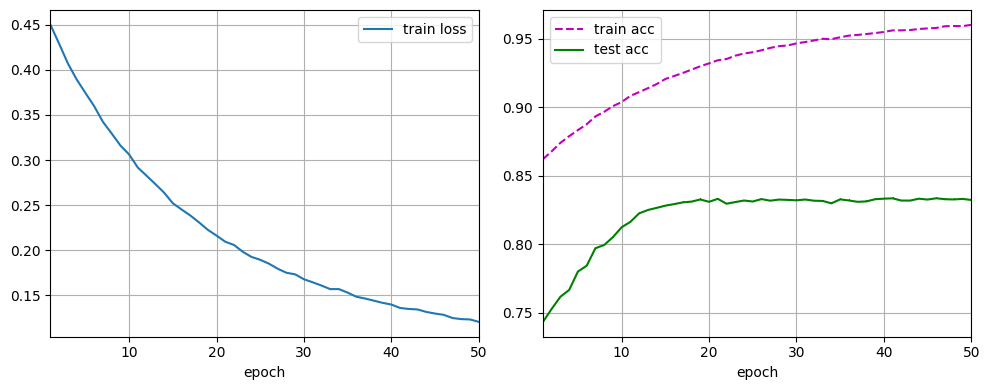

In [16]:
model = ch6.train_SegmentationFCN(model,train_ds,valid_ds,Epochs=50,lr=1e-3,verbose=1)

接下来，我们定义模型的预测组件 `segmentation_predict()` 和 `get_RGBlabel_from_index()`
* `segmentation_predict()` 负责将模型预测得到的概率转换为类别索引
* `get_RGBlabel_from_index()` 可以将类别索引重新映射回 `RGB` 三通道标签

In [17]:
def segmentation_predict(model, image):
    # 将预测概率转换为类别索引
    y_prob = model(image[None,:]) # 增加批量维度
    y_pred = tf.argmax(y_prob,axis=3,output_type=tf.int32)
    return y_pred[0] # 去掉批量维度

def get_RGBlabel_from_index(y_pred):
    # 将类别索引转换为 RGB 像素
    colormap = tf.constant([ch6.VOC_CLASSES[key] for key in ch6.VOC_CLASSES.keys()],dtype=tf.uint8)
    return tf.gather(colormap,y_pred)

我们对模型的预测效果进行测试
* 模型已经**基本学会识别图像各个目标的像素级语义了**
* 为了进一步提升语义分割的效果（包括目标分类准确度，语义区域的分割精度），人们后续又发展了多种技术

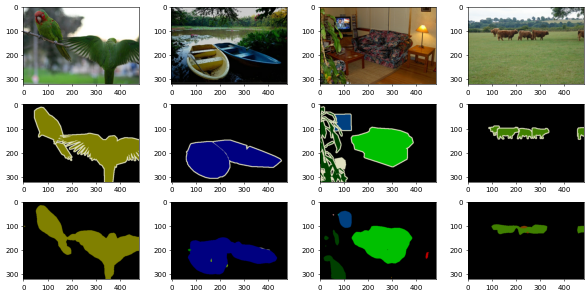

In [25]:
fig, ax = plt.subplots(3,4,figsize=(12,6),dpi=50)
ax = ax.flatten()
samples = [10,20,30,40]
for i, idx in enumerate(samples):
    img, label = train_ds.X[idx], train_ds.Y[idx] # 读取原始图像和标签
    # 随机裁剪到 crop_size
    img, label = ch6.random_crop(img, label, *crop_size)
    img_input = train_ds.normalize(img) # 对输入图像进行归一化

    # 进行预测
    y_pred = ch6.segmentation_predict(model,img_input)
    seg_pred = ch6.get_RGBlabel_from_index(y_pred)
    
    # 绘制预测结果
    ax[i].imshow(img) # 原始图像
    ax[i+4].imshow(label) # ground truth
    ax[i+8].imshow(seg_pred) # 预测结果
plt.tight_layout()

----

### **练习**

1. 在语义分割中，哪些**数据增广方法**可以很好地应用，哪些很难用于语义分割？

2. 导入 `../source/Chap6/wolf_sheep.png`，创建一个**步幅为 2**，**尺寸为 4** 的转置卷积层
    * 输入输出通道均设置为 3，然后对卷积层**进行用双线性插值**初始化
    * 将导入的图像作为输入，绘制对比输入和输出，理解双线性插值的含义，**图像被放大了几倍？**

3. 尝试将我们的语义分割 FCN 网络中的转置卷积层使用 `Xavier` 初始化
    * 重新训练模型，观察模型的性能和预测结果

----